#### Importing Packages

In [144]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [145]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [146]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
import time

#### Multi - Layer Perceptron Algorithm with Backpropagation

In [147]:
class MLP:
    def __init__(self, layer_sizes, activations_hidden, activation_output, alpha=0.9):
        self.layer_sizes = layer_sizes
        self.activation_output = activation_output
        self.activations_hidden = activations_hidden
        self.alpha = alpha 
        
        # Initialize weights, biases and velocities for each layer
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            layer = {}
            layer['W'] = 0.01 * np.random.randn(layer_sizes[i], layer_sizes[i+1])
            layer['b'] = np.zeros((1, layer_sizes[i+1]))
            layer['vW'] = np.zeros_like(layer['W'])
            layer['vb'] = np.zeros_like(layer['b'])
            self.layers.append(layer)
        
    def logistic(self, x):
        a = 2
        # Use a numerically stable sigmoid function
        positive_mask = x >= 0
        negative_mask = x < 0
        z = np.zeros_like(x)
        z[positive_mask] = 1 / (1 + np.exp(-a * x[positive_mask]))
        z[negative_mask] = np.exp(a * x[negative_mask]) / (1 + np.exp(a * x[negative_mask]))
        return z

        
    def logistic_derivative(self, x):
        a = 2
        logistic_x = self.logistic(x)
        return a *logistic_x * (1 - logistic_x)

    def tanh(self, x):
        a = 2
        b = 2 / 3
        return a * np.tanh(b * x)
    
    def tanh_derivative(self, x):
        a = 2
        b = 2 / 3
        tanh_bx = np.tanh(b * x)
        return a * b * (1 - tanh_bx ** 2)
    
    def leaky_relu(self, x):
        return np.where(x > 0, x, 0.01 * x)
    
    def leaky_relu_derivative(self, x):
        return np.where(x > 0, 1, 0.01)
    
    def activation_derivative(self, x, activation):
        if activation == 0:  # logistic
            return self.logistic_derivative(x)
        elif activation == 1:  # tanh
            return self.tanh_derivative(x)
        elif activation == 2:  # leaky ReLU
            return self.leaky_relu_derivative(x)
        else:
            raise ValueError("Invalid activation function index.")

    def forward(self, X):
        self.a = [X]
        for i, layer in enumerate(self.layers):
            z = np.dot(self.a[-1], layer['W']) + layer['b']
            if i != len(self.layers) - 1:  # hidden layers
                activation = self.activations_hidden[i]
                if activation == 0:  # logistic
                    a = self.logistic(z)
                elif activation == 1:  # tanh
                    a = self.tanh(z)
                elif activation == 2:  # leaky ReLU
                    a = self.leaky_relu(z)
            else:  # output layer
                if self.activation_output == 0:  # logistic
                    a = self.logistic(z)
            self.a.append(a)
        return self.a[-1]
    
    def backprop(self, X, y, learning_rate):
        m = X.shape[0]
        dz = [self.a[-1] - y]
        for i in range(len(self.layers) - 1, -1, -1):
            dW = (1 / m) * np.dot(self.a[i].T, dz[-1])
            db = (1 / m) * np.sum(dz[-1], axis=0, keepdims=True)
            if i != 0:  # not input layer
                activation = self.activations_hidden[i-1]
                da = self.activation_derivative(self.a[i], activation)
                dz_next = np.dot(dz[-1], self.layers[i]['W'].T) * da
                dz.append(dz_next)
            # Update velocities with momentum
            self.layers[i]['vW'] = self.alpha * self.layers[i]['vW'] - learning_rate * dW
            self.layers[i]['vb'] = self.alpha * self.layers[i]['vb'] - learning_rate * db
            # Update weights and biases
            self.layers[i]['W'] += self.layers[i]['vW']
            self.layers[i]['b'] += self.layers[i]['vb']
        dz.reverse()  # reverse dz to match the layer order (optional for debugging purposes)

    
    def train(self, X, y, epochs, batch_size=8, learning_rate=0.001, X_val=None, y_val=None):
        self.training_sse = []  # List to store the sum of squared errors
        self.val_sse = []  # List to store the sum of squared errors on validation set
        start_time = time.time()
        lowest_val_sse = float('inf')

        for epoch in range(epochs):
            sse = 0  # Initialize SSE for this epoch
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                # Forward pass
                output = self.forward(X_batch)
                # Calculate sum of squared errors
                sse += np.sum((y_batch - output)**2)
                # Backpropagation
                self.backprop(X_batch, y_batch, learning_rate)
            # Save SSE for this epoch
            self.training_sse.append(sse)
            if X_val is not None and y_val is not None:
                val_output = self.forward(X_val)
                # Calculate sum of squared errors on validation set
                val_sse = np.sum((y_val - val_output)**2)
                # Save lowest validation SSE and corresponding epoch
                if val_sse < lowest_val_sse:
                    lowest_val_sse = val_sse
                    best_epoch = epoch
                self.val_sse.append(val_sse)
        end_time = time.time()
        print("Training completed in {:.2f} seconds.".format(end_time - start_time))
        print("Epoch with lowest validation SSE:", best_epoch)
        print("Lowest validation SSE:", lowest_val_sse)
    
    def predict(self, X):
        return self.forward(X)
    
    def calculate_metrics(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        mcc = matthews_corrcoef(y_true, y_pred)
        return accuracy, precision, recall, f1, mcc

#### Preparing the Dataset

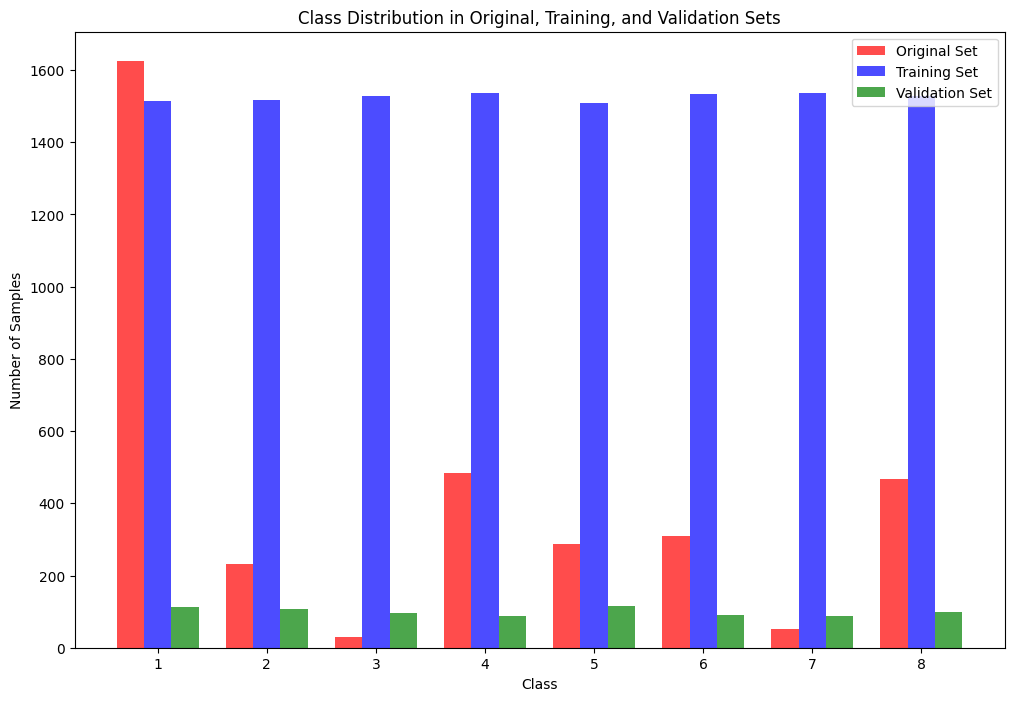

In [148]:
# Read the features and labels data file
X = np.loadtxt('data.csv',delimiter=',') #features
y = np.loadtxt('data_labels.csv',delimiter=',') #labels

# Count the number of samples for each class in the original dataset
original_class_counts = np.bincount(y.astype(int) - 1)  # Subtract 1 to make the labels 0-based

# Apply SMOTE with the determined number of neighbors to balance the classes.
smote = SMOTE(k_neighbors=7)
X_bal, y_bal = smote.fit_resample(X, y)

#One-hot encode the labels
num_classes = len(np.unique(y_bal))
y_encoded = np.eye(num_classes)[(y_bal - 1).astype(int)]  # Subtracting 1 to make the labels 0-based

# Randomize and split the data into training and validation sets
num_val_samples = 800
test_size = num_val_samples / len(X_bal)
X_train, X_val, y_train, y_val = train_test_split(X_bal, y_encoded, test_size=test_size, random_state=42)

# Save the training set and its labels
np.savetxt('training_set.csv', X_train, delimiter=',')
np.savetxt('training_labels.csv', y_train, delimiter=',')

# Save the validation set and its labels
np.savetxt('validation_set.csv', X_val, delimiter=',')
np.savetxt('validation_labels.csv', y_val, delimiter=',')

# Load training and validation sets
X_train = np.loadtxt('training_set.csv', delimiter=',')
y_train = np.loadtxt('training_labels.csv', delimiter=',')
X_val = np.loadtxt('validation_set.csv', delimiter=',')
y_val = np.loadtxt('validation_labels.csv', delimiter=',')

# Convert one-hot encoded labels back to integer labels for plotting
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Count the number of samples for each class in the training set
train_class_counts = np.bincount(y_train_labels, minlength=num_classes)

# Count the number of samples for each class in the validation set
val_class_counts = np.bincount(y_val_labels, minlength=num_classes)

# Plot the class distributions in the original, training, and validation sets
bar_width = 0.25
index = np.arange(1, num_classes + 1)

plt.figure(figsize=(12, 8))
plt.bar(index - bar_width, original_class_counts, bar_width, label='Original Set', color='red', alpha=0.7)
plt.bar(index, train_class_counts, bar_width, label='Training Set', color='blue', alpha=0.7)
plt.bar(index + bar_width, val_class_counts, bar_width, label='Validation Set', color='green', alpha=0.7)

plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Original, Training, and Validation Sets')
plt.xticks(index, range(1, num_classes + 1))
plt.legend()
plt.show()

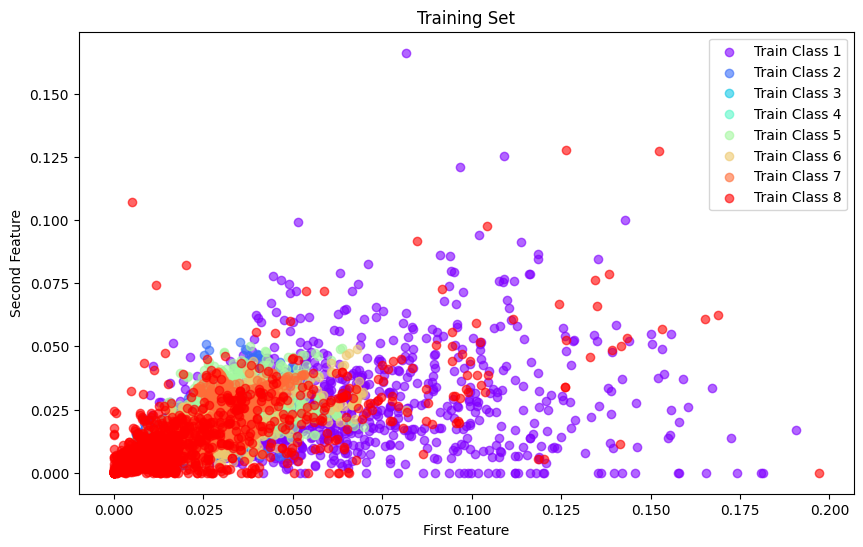

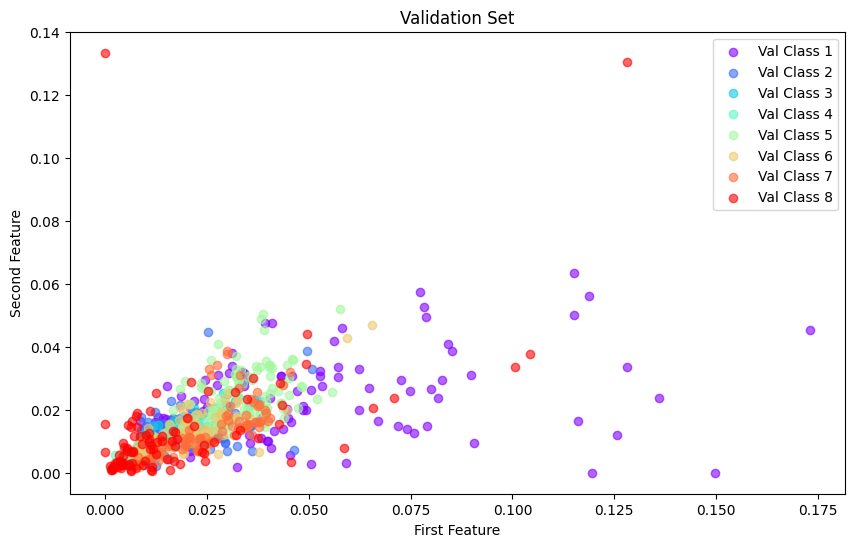

In [149]:
# Define colors for each class
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

# Plot training data
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.scatter(X_train[y_train_labels == i][:, 0], X_train[y_train_labels == i][:, 1],
                color=colors[i], label=f'Train Class {i+1}', alpha=0.6)
plt.xlabel('First Feature')
plt.ylabel('Second Feature')
plt.title('Training Set')
plt.legend()
plt.show()

# Plot validation data
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.scatter(X_val[y_val_labels == i][:, 0], X_val[y_val_labels == i][:, 1],
                color=colors[i], label=f'Val Class {i+1}', alpha=0.6)
plt.xlabel('First Feature')
plt.ylabel('Second Feature')
plt.title('Validation Set')
plt.legend()
plt.show()

Training completed in 43.74 seconds.
Epoch with lowest validation SSE: 41
Lowest validation SSE: 98.62549663878144


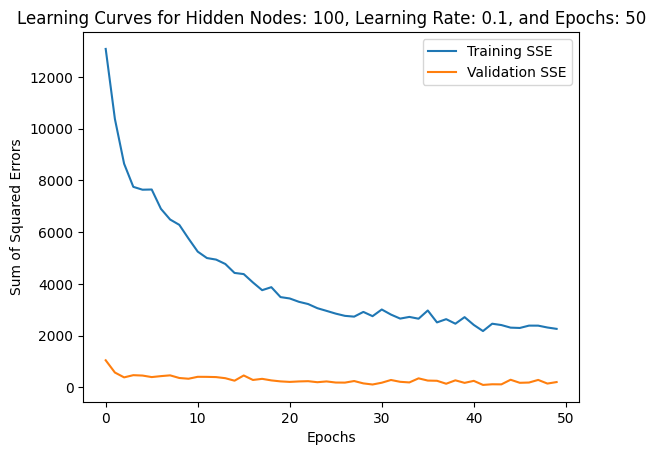

Training completed in 79.58 seconds.
Epoch with lowest validation SSE: 29
Lowest validation SSE: 97.89441783502222


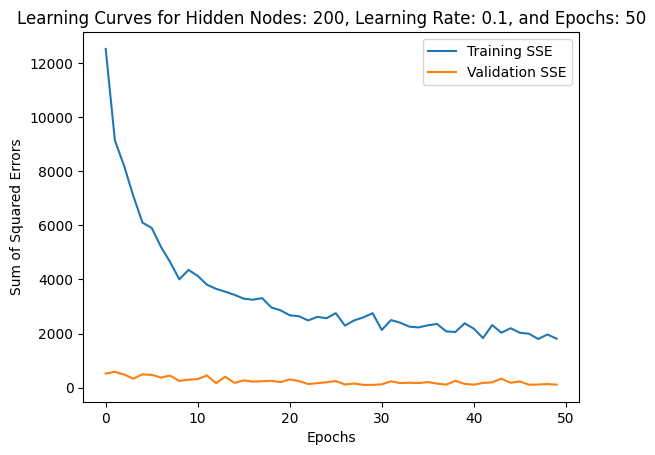

Training completed in 194.47 seconds.
Epoch with lowest validation SSE: 41
Lowest validation SSE: 88.67948833139519


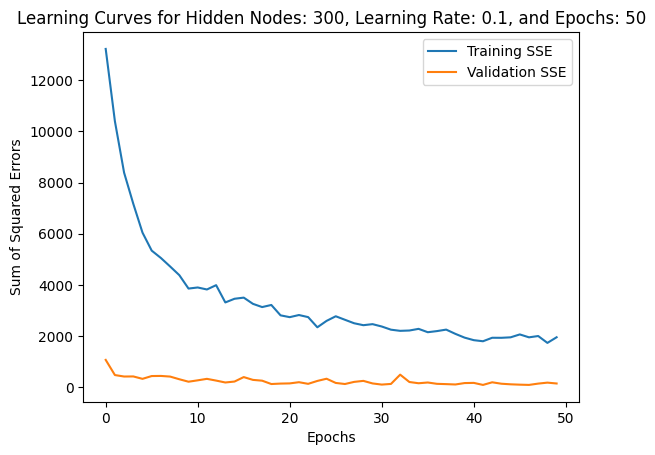

In [164]:
# Initialize and train the 2-hidden-layer perceptron network to find best hyperparameters
#Activation functions: 0 - logistic, 1 - tanh, 2 - leaky ReLU

#Changing the number of hidden nodes

#Trial 1
input_size = X_train.shape[1]
layer_sizes = [input_size, 100, 100, num_classes]
activation_functions = [1,1]
learn_rate = 0.1
epoch_size = 50

trial_a1 = MLP(layer_sizes, activation_functions, 0, alpha=0.9)
trial_a1.train(X_train, y_train, epochs=epoch_size, batch_size=8, learning_rate = learn_rate, X_val=X_val, y_val=y_val)

# Display learning curves
plt.plot(trial_a1.training_sse, label='Training SSE')
plt.plot(trial_a1.val_sse, label='Validation SSE')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title(f'Learning Curves for Hidden Nodes: {layer_sizes[2]}, Learning Rate: {learn_rate}, and Epochs: {epoch_size}')
plt.legend()
plt.show()

#Trial 2
input_size = X_train.shape[1]
layer_sizes = [input_size, 200, 200, num_classes]
activation_functions = [1,1]
learn_rate = 0.1
epoch_size = 50

trial_a2 = MLP(layer_sizes, activation_functions, 0, alpha=0.9)
trial_a2.train(X_train, y_train, epochs=epoch_size, batch_size=8, learning_rate = learn_rate, X_val=X_val, y_val=y_val)

# Display learning curves
plt.plot(trial_a2.training_sse, label='Training SSE')
plt.plot(trial_a2.val_sse, label='Validation SSE')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title(f'Learning Curves for Hidden Nodes: {layer_sizes[2]}, Learning Rate: {learn_rate}, and Epochs: {epoch_size}')
plt.legend()
plt.show()

#Trial 3
input_size = X_train.shape[1]
layer_sizes = [input_size, 300, 300, num_classes]
activation_functions = [1,1]
learn_rate = 0.1
epoch_size = 50

trial_a3 = MLP(layer_sizes, activation_functions, 0, alpha=0.9)
trial_a3.train(X_train, y_train, epochs=epoch_size, batch_size=8, learning_rate = learn_rate, X_val=X_val, y_val=y_val)

# Display learning curves
plt.plot(trial_a3.training_sse, label='Training SSE')
plt.plot(trial_a3.val_sse, label='Validation SSE')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title(f'Learning Curves for Hidden Nodes: {layer_sizes[2]}, Learning Rate: {learn_rate}, and Epochs: {epoch_size}')
plt.legend()
plt.show()

Training completed in 192.27 seconds.
Epoch with lowest validation SSE: 47
Lowest validation SSE: 63.46537147854773


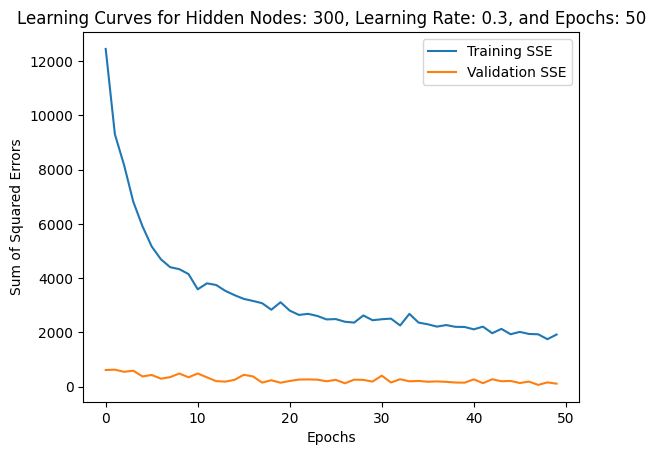

Training completed in 174.65 seconds.
Epoch with lowest validation SSE: 47
Lowest validation SSE: 59.65823012649737


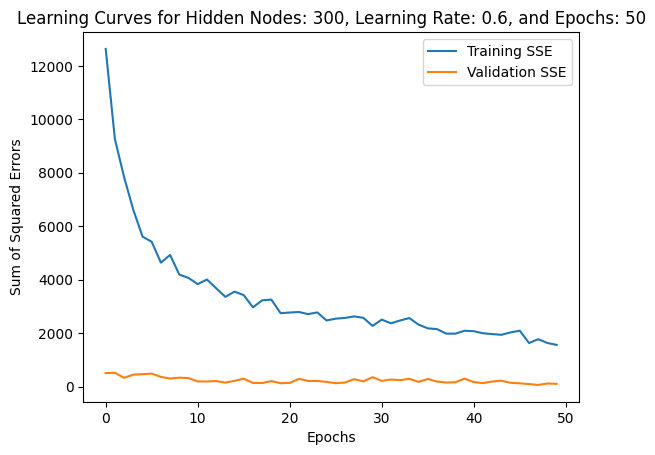

In [165]:
#Increasing the Learning Rate
#Trial 4
input_size = X_train.shape[1]
layer_sizes = [input_size, 300, 300, num_classes]
activation_functions = [1,1]
learn_rate = 0.3
epoch_size = 50

trial_a4 = MLP(layer_sizes, activation_functions, 0, alpha=0.9)
trial_a4.train(X_train, y_train, epochs=epoch_size, batch_size=8, learning_rate = learn_rate, X_val=X_val, y_val=y_val)

# Display learning curves
plt.plot(trial_a4.training_sse, label='Training SSE')
plt.plot(trial_a4.val_sse, label='Validation SSE')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title(f'Learning Curves for Hidden Nodes: {layer_sizes[2]}, Learning Rate: {learn_rate}, and Epochs: {epoch_size}')
plt.legend()
plt.show()

#Trial 5
input_size = X_train.shape[1]
layer_sizes = [input_size, 300, 300, num_classes]
activation_functions = [1,1]
learn_rate = 0.6
epoch_size = 50

trial_a5 = MLP(layer_sizes, activation_functions, 0, alpha=0.9)
trial_a5.train(X_train, y_train, epochs=epoch_size, batch_size=8, learning_rate = learn_rate, X_val=X_val, y_val=y_val)

# Display learning curves
plt.plot(trial_a5.training_sse, label='Training SSE')                           
plt.plot(trial_a5.val_sse, label='Validation SSE')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title(f'Learning Curves for Hidden Nodes: {layer_sizes[2]}, Learning Rate: {learn_rate}, and Epochs: {epoch_size}')
plt.legend()
plt.show()

Training completed in 206.04 seconds.
Epoch with lowest validation SSE: 46
Lowest validation SSE: 71.76380358867755


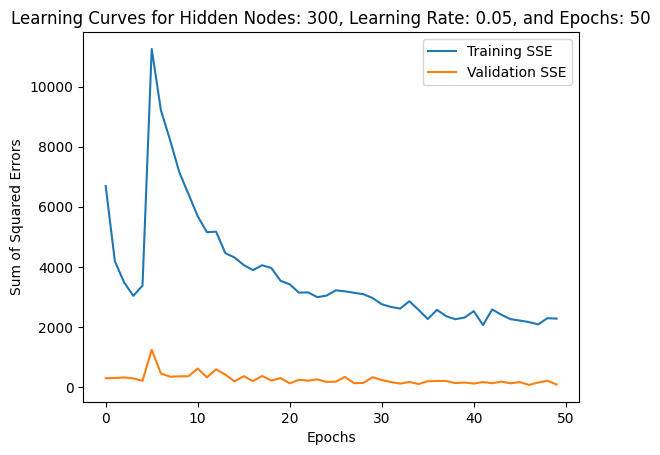

Training completed in 198.47 seconds.
Epoch with lowest validation SSE: 48
Lowest validation SSE: 15.112565387189491


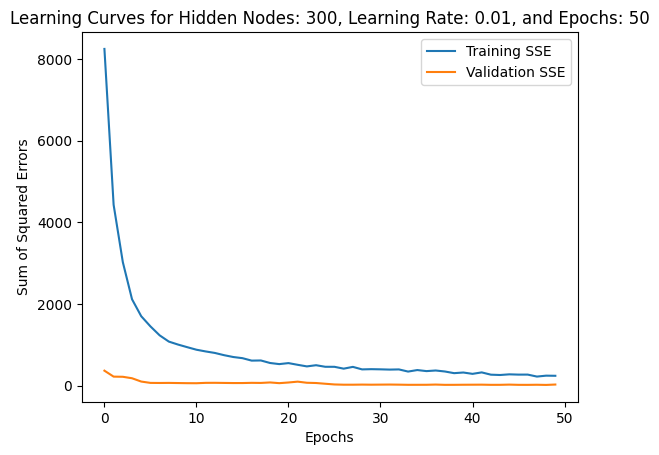

In [166]:
#Decreasing the Learning Rate
#Trial 6
input_size = X_train.shape[1]
layer_sizes = [input_size, 300, 300, num_classes]
activation_functions = [1,1]
learn_rate = 0.05
epoch_size = 50

trial_a6 = MLP(layer_sizes, activation_functions, 0, alpha=0.9)
trial_a6.train(X_train, y_train, epochs=epoch_size, batch_size=8, learning_rate = learn_rate, X_val=X_val, y_val=y_val)

# Display learning curves
plt.plot(trial_a6.training_sse, label='Training SSE')
plt.plot(trial_a6.val_sse, label='Validation SSE')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title(f'Learning Curves for Hidden Nodes: {layer_sizes[2]}, Learning Rate: {learn_rate}, and Epochs: {epoch_size}')
plt.legend()
plt.show()

#Trial 7
input_size = X_train.shape[1]
layer_sizes = [input_size, 300, 300, num_classes]
activation_functions = [1,1]
learn_rate = 0.01
epoch_size = 50

trial_a7 = MLP(layer_sizes, activation_functions, 0, alpha=0.9)
trial_a7.train(X_train, y_train, epochs=epoch_size, batch_size=8, learning_rate = learn_rate, X_val=X_val, y_val=y_val)

# Display learning curves
plt.plot(trial_a7.training_sse, label='Training SSE')
plt.plot(trial_a7.val_sse, label='Validation SSE')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title(f'Learning Curves for Hidden Nodes: {layer_sizes[2]}, Learning Rate: {learn_rate}, and Epochs: {epoch_size}')
plt.legend()
plt.show()

Training completed in 161.86 seconds.
Epoch with lowest validation SSE: 47
Lowest validation SSE: 16.113520149391512


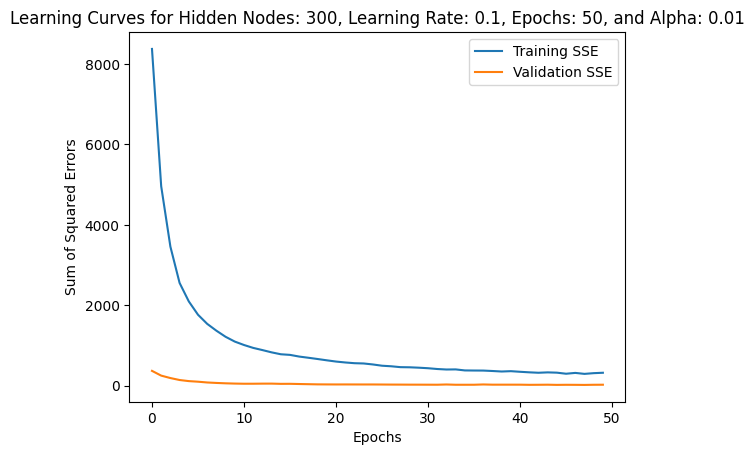

Training completed in 157.96 seconds.
Epoch with lowest validation SSE: 38
Lowest validation SSE: 21.821566193877366


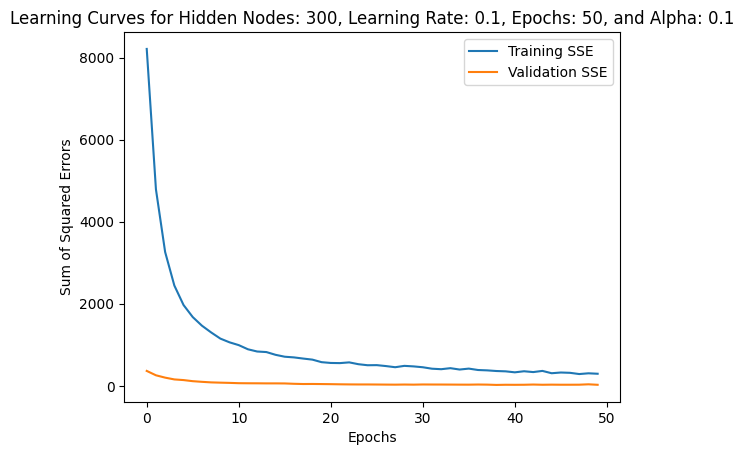

Training completed in 176.41 seconds.
Epoch with lowest validation SSE: 49
Lowest validation SSE: 16.798287239841898


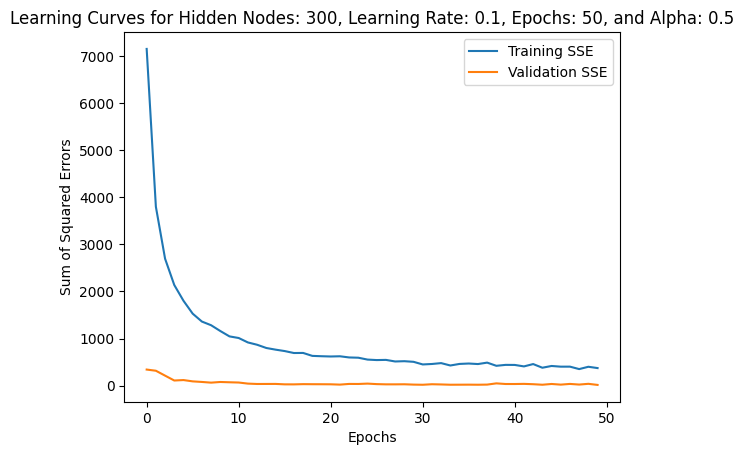

In [153]:
#Modifying Momentum Constant Alpha
#Trial 8
input_size = X_train.shape[1]
layer_sizes = [input_size, 300, 300, num_classes]
activation_functions = [1,1]
learn_rate = 0.1
epoch_size = 50
alpha = 0.01

trial_a8 = MLP(layer_sizes, activation_functions, 0, alpha=alpha)
trial_a8.train(X_train, y_train, epochs=epoch_size, batch_size=8, learning_rate = learn_rate, X_val=X_val, y_val=y_val)

# Display learning curves
plt.plot(trial_a8.training_sse, label='Training SSE')
plt.plot(trial_a8.val_sse, label='Validation SSE')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title(f'Learning Curves for Hidden Nodes: {layer_sizes[2]}, Learning Rate: {learn_rate}, Epochs: {epoch_size}, and Alpha: {alpha}')
plt.legend()
plt.show()

#Trial 9
input_size = X_train.shape[1]
layer_sizes = [input_size, 300, 300, num_classes]
activation_functions = [1,1]
learn_rate = 0.1
epoch_size = 50
alpha = 0.1

trial_a9 = MLP(layer_sizes, activation_functions, 0, alpha=alpha)
trial_a9.train(X_train, y_train, epochs=epoch_size, batch_size=8, learning_rate = learn_rate, X_val=X_val, y_val=y_val)

# Display learning curves
plt.plot(trial_a9.training_sse, label='Training SSE')
plt.plot(trial_a9.val_sse, label='Validation SSE')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title(f'Learning Curves for Hidden Nodes: {layer_sizes[2]}, Learning Rate: {learn_rate}, Epochs: {epoch_size}, and Alpha: {alpha}')
plt.legend()
plt.show()

#Trial 10
input_size = X_train.shape[1]
layer_sizes = [input_size, 300, 300, num_classes]
activation_functions = [1,1]
learn_rate = 0.1
epoch_size = 50
alpha = 0.5

trial_a10 = MLP(layer_sizes, activation_functions, 0, alpha=alpha)
trial_a10.train(X_train, y_train, epochs=epoch_size, batch_size=8, learning_rate = learn_rate, X_val=X_val, y_val=y_val)

# Display learning curves
plt.plot(trial_a10.training_sse, label='Training SSE')
plt.plot(trial_a10.val_sse, label='Validation SSE')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title(f'Learning Curves for Hidden Nodes: {layer_sizes[2]}, Learning Rate: {learn_rate}, Epochs: {epoch_size}, and Alpha: {alpha}')
plt.legend()
plt.show()

#### Training the MLP Network

Training completed in 3940.51 seconds.
Epoch with lowest validation SSE: 347
Lowest validation SSE: 5.631359673094872


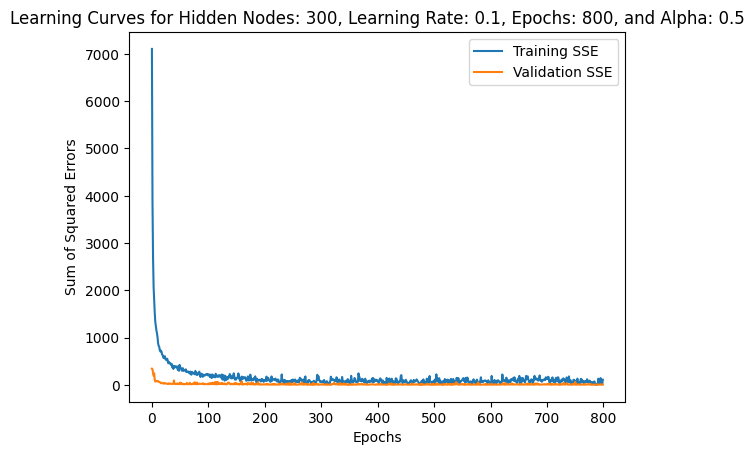

In [158]:
# Initialize and train the 2-hidden-layer perceptron network based on the best hyperparameters
#Activation functions: 0 - logistic, 1 - tanh, 2 - leaky ReLU

input_size = X_train.shape[1]
layer_sizes = [input_size, 300, 300, num_classes]
activation_functions = [1,1]
learn_rate = 0.1
epoch_size = 800
alpha = 0.5

network_a = MLP(layer_sizes, activation_functions, 0, alpha=alpha)
network_a.train(X_train, y_train, epochs=epoch_size, batch_size=8, learning_rate = learn_rate, X_val=X_val, y_val=y_val)

# Display learning curves
plt.plot(network_a.training_sse, label='Training SSE')
plt.plot(network_a.val_sse, label='Validation SSE')
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title(f'Learning Curves for Hidden Nodes: {layer_sizes[2]}, Learning Rate: {learn_rate}, Epochs: {epoch_size}, and Alpha: {alpha}')
plt.legend()
plt.show()

# Save SSE per epoch
np.savetxt('SSE_per_epoch.csv', np.array(network_a.training_sse), delimiter=',')

# Save the trained weights and biases
weights_and_biases = np.concatenate([layer['W'].flatten() for layer in network_a.layers] + [layer['b'].flatten() for layer in network_a.layers])
np.savetxt('trained_weights_and_biases.csv', weights_and_biases, delimiter=',')

#### Network A

Network A Evaluation Metrics:
Accuracy: 0.06375
Precision: 0.013650192364604912
Recall: 0.06375
F1-score: 0.022467136130567375
Matthews Correlation Coefficient: -0.0883689532004064


/Users/janila2/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


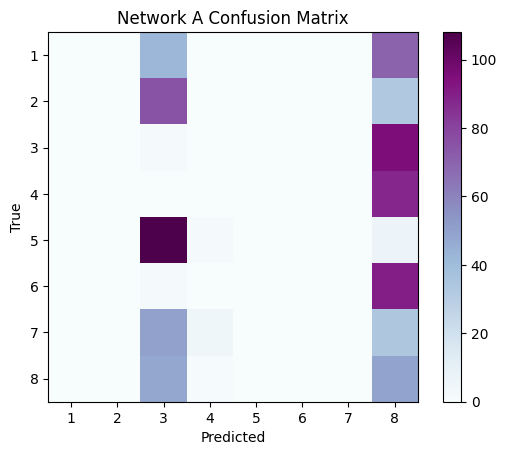

In [159]:
# Define tanh and logistic functions
def tanh(x):
    a = 2
    b = 2 / 3
    return a * np.tanh(b * x)

def logistic(x):
    a = 2
    # Use a numerically stable sigmoid function
    positive_mask = x >= 0
    negative_mask = x < 0
    z = np.zeros_like(x)
    z[positive_mask] = 1 / (1 + np.exp(-a * x[positive_mask]))
    z[negative_mask] = np.exp(a * x[negative_mask]) / (1 + np.exp(a * x[negative_mask]))
    return z

# Load trained weights and biases
trained_weights = np.loadtxt('trained_weights_and_biases.csv', delimiter=',')

# Define forward propagation function using loaded weights and specified activation functions
def forward(X,trained_weights):

    offset = 0

    input_size = X_test.shape[1]  # Assuming X_test is already loaded
    hidden_size1 = 300
    hidden_size2 = 300
    num_classes = 8

    num_params_W1 = input_size * hidden_size1
    num_params_b1 = hidden_size1
    num_params_W2 = hidden_size1 * hidden_size2
    num_params_b2 = hidden_size2
    num_params_W3 = hidden_size2 * num_classes
    num_params_b3 = num_classes

    W1 = trained_weights[offset:offset + num_params_W1].reshape(input_size, hidden_size1)
    offset += num_params_W1
    b1 = trained_weights[offset:offset + num_params_b1].reshape(1, hidden_size1)
    offset += num_params_b1
    
    W2 = trained_weights[offset:offset + num_params_W2].reshape(hidden_size1, hidden_size2)
    offset += num_params_W2
    b2 = trained_weights[offset:offset + num_params_b2].reshape(1, hidden_size2)
    offset += num_params_b2
    
    W3 = trained_weights[offset:offset + num_params_W3].reshape(hidden_size2, num_classes)
    offset += num_params_W3
    b3 = trained_weights[offset:offset + num_params_b3].reshape(1, num_classes)
    
    z1 = np.dot(X, W1) + b1
    a1 = tanh(z1)
    
    z2 = np.dot(a1, W2) + b2
    a2 = tanh(z2)
    
    z3 = np.dot(a2, W3) + b3
    a3 = logistic(z3)
    
    return a3

# Load test set
X_test = np.loadtxt('validation_set.csv',delimiter=',') #test set

# Predict labels for test set
predicted_probs = forward(X_test, trained_weights)
predicted_labels = np.argmax(predicted_probs, axis=1) + 1  # Convert one-hot encoded outputs to class labels

# Save predicted labels
np.savetxt('predictions_for_test_tanh.csv', predicted_labels, delimiter=',', fmt='%d')

# Load true labels for test set
true_labels_one_hot = np.loadtxt('validation_labels.csv', delimiter=',')
true_labels = np.argmax(true_labels_one_hot, axis=1) + 1

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Save confusion matrix with headings
header = 'Predicted,' + ','.join(map(str, range(1, num_classes+1)))
np.savetxt('Network_A_Confusion_matrix.csv', conf_matrix, delimiter=',', fmt='%d', header=header, comments='')

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
mcc = matthews_corrcoef(true_labels, predicted_labels)

# Save metrics
with open('Network_A_Evaluation.csv', 'w') as file:
    file.write(f'Accuracy,Precision,Recall,F1-score,Matthews Correlation Coefficient\n')
    file.write(f'{accuracy},{precision},{recall},{f1},{mcc}\n')

print("Network A Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Matthews Correlation Coefficient: {mcc}")

# Plot confusion matrix
plt.imshow(conf_matrix, cmap='BuPu')
plt.xticks(range(conf_matrix.shape[1]), range(1, conf_matrix.shape[1] + 1))
plt.yticks(range(conf_matrix.shape[0]), range(1, conf_matrix.shape[0] + 1))
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Network A Confusion Matrix')
plt.show()

#### Network B

Training completed in 2867.83 seconds.
Epoch with lowest validation SSE: 210
Lowest validation SSE: 5.401230918514314


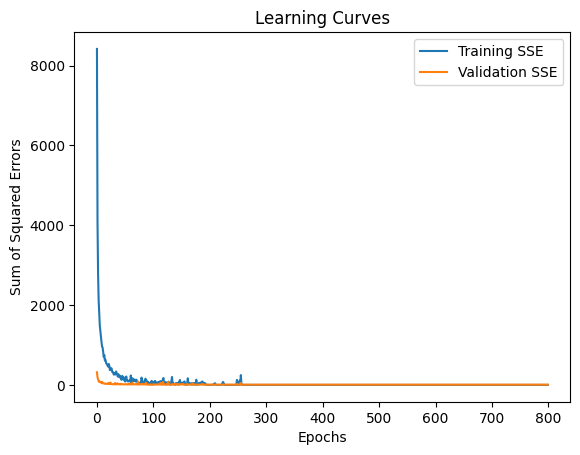

New Network B Evaluation Metrics:
Accuracy: 0.995
Precision: 0.9950954545454544
Recall: 0.995
F1-score: 0.9949990966275369
Matthews Correlation Coefficient: 0.9942916619777185


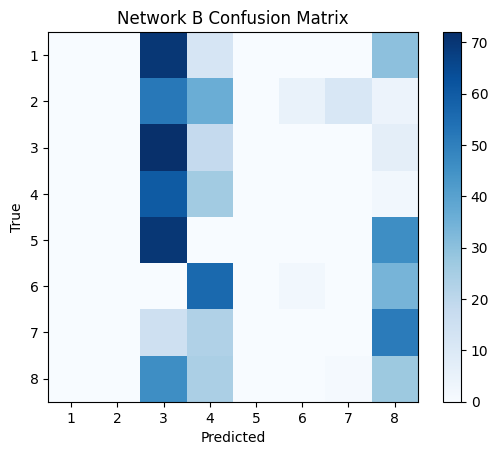

In [162]:
# Load training and validation sets
X_train = np.loadtxt('training_set.csv', delimiter=',')
y_train = np.loadtxt('training_labels.csv', delimiter=',')
X_val = np.loadtxt('validation_set.csv', delimiter=',')
y_val = np.loadtxt('validation_labels.csv', delimiter=',')

# Define Network B class
class NetworkB(MLP):
    def __init__(self, layer_sizes, activation_hidden, activation_output, alpha=0.9):
        super().__init__(layer_sizes, activation_hidden, activation_output, alpha)
    
    def train_and_validate(self, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate):
        self.training_sse = []  # List to store sum of square errors for training set
        self.val_sse = []  # List to store sum of square errors for validation set
        lowest_val_sse = float('inf')
        best_epoch = 0
        start_time = time.time()

        for epoch in range(epochs):
            train_sse = 0  # Initialize SSE for this epoch for training set
            val_sse = 0  # Initialize SSE for this epoch for validation set
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                # Forward pass
                output = self.forward(X_batch)
                # Calculate sum of square errors for training set
                train_sse += np.sum((y_batch - output)**2)
                # Backpropagation
                self.backprop(X_batch, y_batch, learning_rate)
            # Save SSE for this epoch for training set
            self.training_sse.append(train_sse)
            # Calculate SSE for validation set
            val_output = self.forward(X_val)
            val_sse = np.sum((y_val - val_output)**2)
            # Save SSE for this epoch for validation set
            self.val_sse.append(val_sse)
            # Update lowest validation SSE and corresponding epoch
            if val_sse < lowest_val_sse:
                lowest_val_sse = val_sse
                best_epoch = epoch
        end_time = time.time()
        # Print epoch with lowest validation error
        print("Training completed in {:.2f} seconds.".format(end_time - start_time))
        print("Epoch with lowest validation SSE:", best_epoch)
        print("Lowest validation SSE:", lowest_val_sse)
        # Plot learning curves
        plt.plot(self.training_sse, label='Training SSE')
        plt.plot(self.val_sse, label='Validation SSE')
        plt.xlabel('Epochs')
        plt.ylabel('Sum of Squared Errors')
        plt.title('Learning Curves')
        plt.legend()
        plt.show()

        # Save training metrics
        np.savetxt('NetworkB_SSE.csv', np.array(self.training_sse), delimiter=',')
        # Save trained weights
        weights_and_biases = np.concatenate([layer['W'].flatten() for layer in self.layers] + [layer['b'].flatten() for layer in self.layers])
        np.savetxt('NetworkB_Trained_Weights.csv', weights_and_biases, delimiter=',')


# Initialize Network B
input_size = X_train.shape[1]
num_classes = 8
layer_sizes = [input_size, 300, 300, num_classes]
activation_functions = [2,2]
learn_rate = 0.1
epoch_size = 800
alpha = 0.5

network_b = NetworkB(layer_sizes, activation_functions, 0, alpha=alpha)

# Train and validate Network B
network_b.train_and_validate(X_train, y_train, X_val, y_val, epochs=epoch_size, batch_size = 8, learning_rate = learn_rate)

# Generate predictions for the test set using Network B
X_test = np.loadtxt('validation_set.csv', delimiter=',')
predicted_labels = np.argmax(network_b.predict(X_test), axis=1) + 1  # Convert one-hot encoded outputs to class labels

# Save predicted labels for Network B
np.savetxt('predictions_for_test_leakyrelu.csv', predicted_labels, delimiter=',', fmt='%d')

# Load true labels for test set
true_labels_one_hot = np.loadtxt('validation_labels.csv', delimiter=',')
true_labels = np.argmax(true_labels_one_hot, axis=1) + 1

# Calculate evaluation metrics for Network B
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
mcc = matthews_corrcoef(true_labels, predicted_labels)

print("New Network B Evaluation Metrics:")
print(f"Accuracy: {accuracy}") 
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Matthews Correlation Coefficient: {mcc}")

# Plot confusion matrix
plt.imshow(conf_matrix, cmap='Blues')
plt.xticks(range(num_classes), range(1, num_classes+1))
plt.yticks(range(num_classes), range(1, num_classes+1))
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Network B Confusion Matrix')
plt.show()

# Save evaluation metrics for Network B
with open('New_NetworkB_Metrics.csv', 'w') as file:
    file.write(f'Accuracy,Precision,Recall,F1-score,Matthews Correlation Coefficient\n')
    file.write(f'{accuracy},{precision},{recall},{f1},{mcc}\n')